#  QAM Demodulation in Nonlinear Channels with Deep Neural Networks

This code is provided as supplementary material of the invited presentation at ECOC 2020 by Laurent Schmalen

> Boris Karanov, Polina Bayvel, and Laurent Schmalen, "End-to-end Learning in Optical Fiber Communications: Concept and Transceiver Design," Proc. European Conference on Optical Communications (ECOC), Brussels, Belgium, Dec. 2020

This code illustrates:
* Demodulation of QAM symbols in AWGN channels
* Demodulation of QAM symbols in nonlinear channels using an artificial neural network
* variable batch size to improve learning towards lower error rates

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


We use deep neural networks to show symbol detection in the AWGN channel for two different constellations: 16-QAM and 16-APSK.

#### Channel Model 1: AWGN Channel 
The AWGN channel just adds complex additive white Gaussian noise (AWGN) of variance $N_0$. The noise samples $n_k$ are given as
$$
n_k = n_{k,\textrm{I}} + \jmath n_{k,\textrm{Q}}
$$
where
$$
n_{k,\textrm{I}/\textrm{Q}} = \mathcal{N}(0, N_0/2)
$$
i.e., each dimension is affected by Gaussian noise of variance $\sigma_n^2 = N_0/2$.

In [2]:
constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6])}


# permute constellations so that it is visually more appealing with the chosen colormap
for cname in constellations.keys():
    constellations[cname] = constellations[cname][np.random.permutation(len(constellations[cname]))]


def simulate_channel(x, EsN0, constellation):  
    sigma_n = np.sqrt((1/2) * 10**(-EsN0/10))

    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2))        
    modulated = constellation[x] * norm_factor
    temp = modulated + sigma_n*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
        
    return temp

We consider BPSK transmission over this channel.

Show constellation as a function of the fiber input power for the nonlinear channel. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

In [3]:
length_plot = 6000

def plot_constellation(EsN0, constellation_name):
    constellation = constellations[constellation_name]
    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2))      
        
    t = np.random.randint(len(constellation),size=length_plot)
    r = simulate_channel(t, EsN0, constellation)

    plt.figure(figsize=(12,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    plt.subplot(1,2,2)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='tab20',s=4)
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
    plt.title('Received constellation ($E_s/N_0 = %1.2f$\,dBm)' % (EsN0))        

    plt.subplot(1,2,1)
    r_tx = constellation[range(len(constellation))] * norm_factor
    plt.scatter(np.real(r_tx), np.imag(r_tx), c=range(len(constellation)), marker='o', s=200, cmap='tab20')
    plt.xticks(())
    plt.yticks(())
    plt.axis('equal')
    plt.gca().set_xlim(xlim)
    plt.gca().set_ylim(ylim)
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.title('Transmitted constellation')
    
    
interactive_update = interactive(plot_constellation, \
                                 EsN0 = widgets.FloatSlider(min=9.0,max=20.0,step=0.1,value=12, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')), \
                                 constellation_name = widgets.RadioButtons(options=['16-QAM','16-APSK'], value='16-QAM',continuous_update=False,description='Constellation'))


output = interactive_update.children[-1]
output.layout.height = '400px'
interactive_update

interactive(children=(FloatSlider(value=12.0, continuous_update=False, description='Input Power Pin (dBm)', la…

Helper function to compute Bit Error Rate (BER)

In [4]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [5]:
#define constellation
constellation = constellations['16-QAM']

# channel SNR at which the learning is carried out
EsN0 = 14

sigma_n = np.sqrt((1/2) * 10**(-EsN0/10))
norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2))
constellation_mat = np.stack([constellation.real * norm_factor, constellation.imag * norm_factor],axis=1)
    


# validation set. Training examples are generated on the fly
N_valid = 100000

# number of neurons in hidden layers
hidden_neurons_1 = 50
hidden_neurons_2 = 50
hidden_neurons_3 = 50
hidden_neurons_4 = 50



y_valid = np.random.randint(len(constellation),size=N_valid)
r = simulate_channel(y_valid, EsN0, constellation)

# find extension of data (for normalization and plotting)
ext_x = max(abs(np.real(r)))
ext_y = max(abs(np.imag(r)))
ext_max = max(ext_x,ext_y)*1.2

# scale data to be between 0 and 1
X_valid = torch.from_numpy(np.column_stack((np.real(r), np.imag(r))) / ext_max).float().to(device)


# meshgrid for plotting
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = torch.from_numpy(np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) / ext_max).float().to(device)

This is the main neural network with 4 hidden layers, each with ELU activation function. Note that the final layer does *not* use a `softmax` function, as this function is already included in the `CrossEntropyLoss`.

In [6]:
class Receiver_Network(nn.Module):
    def __init__(self, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, hidden_neurons_4):
        super(Receiver_Network, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(2, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
       
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Another hidden layer
        self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
        
        # Another hidden layer
        self.fc4 = nn.Linear(hidden_neurons_3, hidden_neurons_4)
        
        # Output layer
        self.fc5 = nn.Linear(hidden_neurons_4, len(constellation))
        

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, third layer
        out = self.fc3(out)

        # Non-linearity, third layer
        out = self.activation_function(out)
        
        # Linear function, fourth layer
        out = self.fc4(out)
        
        # Non-linearity, fourth layer
        out = self.activation_function(out)

        # Linear function, output layer
        out = self.fc5(out)
        
        # Do *not* apply softmax, as it is already included in the CrossEntropyLoss
        
        return out

This is the main learning function, generate the data directly on the GPU (if available) and the run the neural network. We use a variable batch size that varies during training. In the first iterations, we start with a small batch size to rapidly get to a working solution. The closer we come towards the end of the training we increase the batch size. If keeping the batch size small, it may happen that there are no misclassifications in a small batch and there is no incentive of the training to improve. A larger batch size will most likely contain errors in the batch and hence there will be incentive to keep on training and improving. 

Here, the data is generated on the fly inside the graph, by using PyTorchs random number generation. As PyTorch does not natively support complex numbers (at least in early versions), we decided to replace the complex number operations in the channel by an equivalent simple rotation matrix and treating real and imaginary parts separately.

We employ the Adam optimization algorithm. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data.

In [8]:
model = Receiver_Network(hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, hidden_neurons_4)
model.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  

# Softmax function
softmax = nn.Softmax(dim=1)

# each epoch corresponds to one frame in the GIF file. For having a fine resolutino, choose a larger number with small number of batches_per_epoch
num_epochs = 50
batches_per_epoch = 100

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs)

validation_SERs = np.zeros(num_epochs)
decision_region_evolution = []

constellation_tensor = torch.from_numpy(constellation_mat).float().to(device)


for epoch in range(num_epochs):
    batch_labels = torch.empty(int(batch_size_per_epoch[epoch]), device=device)
    noise = torch.empty((int(batch_size_per_epoch[epoch]),2), device=device, requires_grad=False)        

    for step in range(batches_per_epoch):
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(len(constellation))

        temp_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), len(constellation), device=device)
        temp_onehot[range(temp_onehot.shape[0]), batch_labels.long()]=1
        
        # channel simulation directly on the GPU
        qam = (temp_onehot @ constellation_tensor).to(device)
        
        noise.normal_(mean=0, std=sigma_n)
        qam += noise

        qam = qam / ext_max
        outputs = model(qam)

        # compute loss
        loss = loss_fn(outputs.squeeze(), batch_labels.long())
        
        # compute gradients
        loss.backward()
        
        optimizer.step()
        # reset gradients
        optimizer.zero_grad()
        
    # compute validation SER
    out_valid = softmax(model(X_valid))
    validation_SERs[epoch] = SER(out_valid.detach().cpu().numpy(), y_valid)
    
    print('Validation SER after epoch %d: %f (loss %1.8f)' % (epoch, validation_SERs[epoch], loss.detach().cpu().numpy()))                
        
    # store decision region for generating the animation    
    mesh_prediction = softmax(model(meshgrid))    
    decision_region_evolution.append(0.195*mesh_prediction.detach().cpu().numpy() + 0.4)


Validation SER after epoch 0: 0.685330 (loss 2.57463980)
Validation SER after epoch 1: 0.727080 (loss 1.94141531)
Validation SER after epoch 2: 0.467130 (loss 1.38167799)
Validation SER after epoch 3: 0.227810 (loss 0.95033073)
Validation SER after epoch 4: 0.098770 (loss 0.53680289)
Validation SER after epoch 5: 0.059200 (loss 0.30482990)
Validation SER after epoch 6: 0.051000 (loss 0.18590313)
Validation SER after epoch 7: 0.050490 (loss 0.15741241)
Validation SER after epoch 8: 0.047980 (loss 0.11870063)
Validation SER after epoch 9: 0.045770 (loss 0.10499600)
Validation SER after epoch 10: 0.043550 (loss 0.13760264)
Validation SER after epoch 11: 0.042990 (loss 0.14356579)
Validation SER after epoch 12: 0.042540 (loss 0.12601279)
Validation SER after epoch 13: 0.041020 (loss 0.12703338)
Validation SER after epoch 14: 0.042600 (loss 0.09667350)
Validation SER after epoch 15: 0.040590 (loss 0.12197289)
Validation SER after epoch 16: 0.040430 (loss 0.10761597)
Validation SER after epo

Validation SER after epoch 141: 0.037930 (loss 0.11431749)
Validation SER after epoch 142: 0.038230 (loss 0.10142332)
Validation SER after epoch 143: 0.037690 (loss 0.10441769)
Validation SER after epoch 144: 0.037700 (loss 0.10560647)
Validation SER after epoch 145: 0.038040 (loss 0.09640019)
Validation SER after epoch 146: 0.037880 (loss 0.11117191)
Validation SER after epoch 147: 0.037950 (loss 0.09669652)
Validation SER after epoch 148: 0.037550 (loss 0.10711386)
Validation SER after epoch 149: 0.037660 (loss 0.10662410)
Validation SER after epoch 150: 0.037830 (loss 0.10496154)
Validation SER after epoch 151: 0.037990 (loss 0.10414341)
Validation SER after epoch 152: 0.037710 (loss 0.11920741)
Validation SER after epoch 153: 0.038760 (loss 0.10792726)
Validation SER after epoch 154: 0.038010 (loss 0.10501883)
Validation SER after epoch 155: 0.038170 (loss 0.10551448)
Validation SER after epoch 156: 0.038030 (loss 0.09800566)
Validation SER after epoch 157: 0.038210 (loss 0.1061167

Plt decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing BERs and plotting, there is no feedback towards the training!

In [9]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

# find minimum SER from validation set
min_SER_iter = np.argmin(validation_SERs)

Text(0.5, 1.0, 'Decision region after learning')

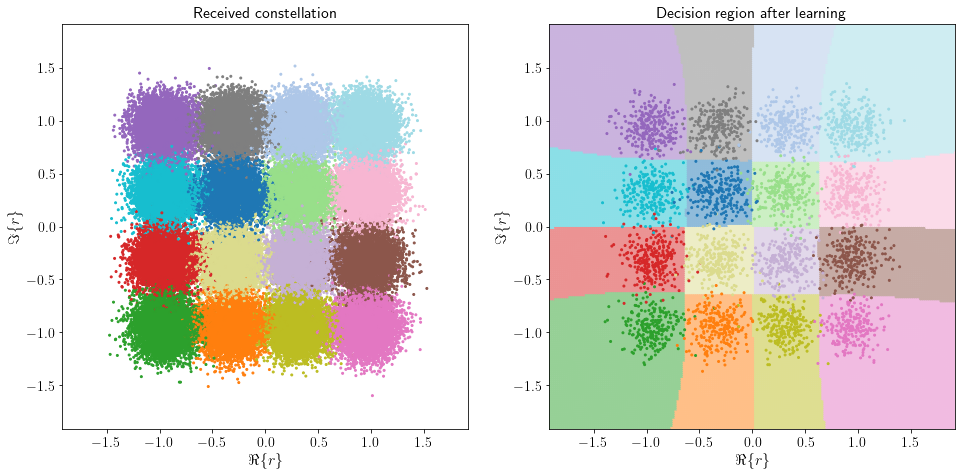

In [10]:
plt.figure(figsize=(16,8))
plt.subplot(121)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(X_valid.cpu()[:,0]*ext_max, X_valid.cpu()[:,1]*ext_max, c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.title('Received constellation',fontsize=16)

#light_tab20 = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.tab20)
plt.subplot(122)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid.cpu()[:,0] * ext_max, meshgrid.cpu()[:,1] * ext_max, c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(X_valid.cpu()[0:4000,0]*ext_max, X_valid.cpu()[0:4000,1]*ext_max, c=y_valid[0:4000], cmap='tab20',s=4)
plt.axis('scaled')
plt.xlim((-ext_max,ext_max))
plt.ylim((-ext_max,ext_max))
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
plt.title('Decision region after learning',fontsize=16)

#plt.savefig('decision_region_16APSK_Pin%d.pdf' % Pin,bbox_inches='tight')

Generate animation and save as a gif.

<IPython.core.display.Javascript object>


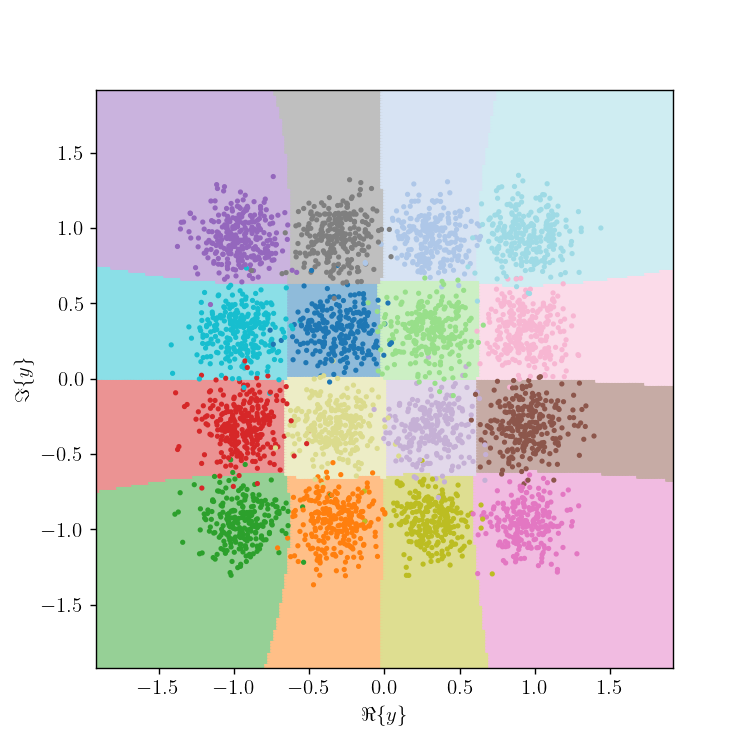

In [19]:
%matplotlib notebook
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 12}
plt.rc('font', **font)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.axis('scaled')

written = False
def animate(i):
    ax.clear()
    decision_scatter = np.argmax(decision_region_evolution[i], 1)
    
    plt.scatter(meshgrid.cpu()[:,0] * ext_max, meshgrid.cpu()[:,1] * ext_max, c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4, marker='s')
    plt.scatter(X_valid.cpu()[0:4000,0]*ext_max, X_valid.cpu()[0:4000,1]*ext_max, c=y_valid[0:4000], cmap='tab20',s=4)
    ax.set_xlim(( -ext_max, ext_max))
    ax.set_ylim(( -ext_max, ext_max))

    ax.set_xlabel(r'$\Re\{y\}$',fontsize=12)
    ax.set_ylabel(r'$\Im\{y\}$',fontsize=12)

    
anim = animation.FuncAnimation(fig, animate, frames=min_SER_iter+1, interval=200, blit=False)
fig.show()

In [20]:
anim.save('learning_decision_16QAM.gif', writer=PillowWriter(fps=5))